In [102]:
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd
import re

# ---------- 設定 ----------
base_url = 'https://tabelog.com/oita/rstLst'
tag_log = 'MC0101'
sleep_time = 1

GET_ONLY_FIRST_PAGE = False
if GET_ONLY_FIRST_PAGE:
    csv_filename = f'tabelog_{tag_log}_oita_page1_simplified.csv'
    print("【モード】1ページ目のみ取得")
else:
    csv_filename = f'tabelog_{tag_log}_oita_all_pages_simplified.csv'
    print("【モード】全ページ取得")

shop_data_list = []
page = 1

# --- 拡張分類（表記ゆれ対応済） ---
flavor_patterns = [
    (re.compile(r'(豚骨|とんこつ|トンコツ)', re.I), "豚骨"),
    (re.compile(r'(醤油|しょうゆ|ショウユ)', re.I), "醤油"),
    (re.compile(r'(味噌|みそ|ミソ)', re.I), "味噌"),
    (re.compile(r'(塩|しお|シオ)', re.I), "塩"),
    (re.compile(r'(中華そば|ちゅうかそば|チュウカソバ)', re.I), "中華そば"),
    (re.compile(r'(つけ麺|つけめん|ツケメン)', re.I), "つけ麺"),
    (re.compile(r'(担々麺|坦々麺|たんたんめん|タンタンメン)', re.I), "担々麺"),
    (re.compile(r'(魚介|ぎょかい|ギョカイ|煮干し|にぼし|ニボシ|魚粉|ぎょふん|ギョフン|節系|ぶし|ブシ)', re.I), "魚介"),
    (re.compile(r'(鶏白湯|とりぱいたん|トリパイタン|鶏ガラ|とりがら|トリガラ)', re.I), "鶏白湯"),
    (re.compile(r'(油そば|あぶらそば|アブラソバ|まぜそば|まぜソバ|マゼソバ)', re.I), "油そば・まぜそば"),
    (re.compile(r'(家系|いえけい|イエケイ)', re.I), "家系"),
    (re.compile(r'(二郎系|じろうけい|ジロウケイ)', re.I), "二郎系"),
    (re.compile(r'(背脂|せあぶら|セアブラ)', re.I), "背脂"),
    (re.compile(r'(白湯|ぱいたん|パイタン)', re.I), "白湯"),
    (re.compile(r'(激辛|げきから|ゲキカラ|辛口|からくち|カラクチ|ピリ辛|ぴりから|ピリカラ)', re.I), "激辛"),
]

def get_flavor_count(comments):
    count = {kanji: 0 for _, kanji in flavor_patterns}
    for comment in comments:
        for pattern, kanji in flavor_patterns:
            if pattern.search(comment):
                count[kanji] += 1
    return count

def extract_comments(url, batch=5, max_batch=5):
    all_comments = []
    offset = 0
    for _ in range(max_batch):
        try:
            res = requests.get(url)
            res.raise_for_status()
        except Exception as e:
            break
        soup = BeautifulSoup(res.text, 'html.parser')
        comment_tags = soup.find_all('div', class_='rvw-item__rvw-comment rvw-item__rvw-comment--custom')
        batch_comments = []
        for tag in comment_tags[offset:offset+batch]:
            p_tag = tag.find('p')
            if p_tag:
                batch_comments.append(p_tag.get_text(strip=True))
        if batch_comments:
            all_comments.extend(batch_comments)
            yield batch_comments
            offset += batch
        else:
            break

def get_representative_flavor(dtlrvw_url):
    for batch_comments in extract_comments(dtlrvw_url):
        flavor_count = get_flavor_count(batch_comments)
        sorted_flavor = sorted(flavor_count.items(), key=lambda x: x[1], reverse=True)
        if sorted_flavor and sorted_flavor[0][1] > 0:
            return sorted_flavor[0][0]
    return "不明"

while True:
    url = f'{base_url}/{tag_log}/{page}/'
    print(f"\n--- {page}ページ目を取得中 ---\nURL: {url}")

    try:
        response = requests.get(url)
        response.raise_for_status()
    except requests.exceptions.RequestException as e:
        print(f"ページ取得失敗: {url} -> {e}")
        break

    soup = BeautifulSoup(response.text, 'html.parser')
    shop_cards = soup.select('div.list-rst')

    if not shop_cards:
        print("このページに店舗情報が見つかりませんでした。")
        break

    for card in shop_cards:
        try:
            name_tag = card.select_one('a.list-rst__rst-name-target')
            name = name_tag.get_text(strip=True) if name_tag else '取得失敗'
            shop_url = name_tag['href'] if name_tag else None
            if not shop_url: continue

            print(f"店舗「{name}」の情報を処理中...")

            area_genre_tag = card.select_one('div.list-rst__area-genre')
            city = '取得失敗'
            if area_genre_tag:
                full_text = area_genre_tag.get_text(strip=True)
                city = full_text.split('/')[0].strip()

            rating_tag = card.select_one('span.c-rating__val')
            rating = rating_tag.get_text(strip=True) if rating_tag else '-'
            review_count_tag = card.select_one('em.list-rst__rvw-count-num')
            review_count = review_count_tag.get_text(strip=True).replace(',', '') if review_count_tag else '0'
            bookmark_count_tag = card.select_one('span.list-rst__save-count-num')
            bookmark_count = bookmark_count_tag.get_text(strip=True).replace(',', '') if bookmark_count_tag else '0'

            res_detail = requests.get(shop_url)
            res_detail.raise_for_status()
            shop_soup = BeautifulSoup(res_detail.text, 'html.parser')

            address = shop_soup.find('p', class_='rstinfo-table__address').get_text(strip=True) if shop_soup.find('p', class_='rstinfo-table__address') else '記載なし'

            # 代表味分類を取得
            dtlrvw_url = shop_url.rstrip('/') + '/dtlrvwlst/'
            representative_flavor = get_representative_flavor(dtlrvw_url)

            shop_data_list.append({
                '店名': name,
                '評価': rating,
                'レビュー数': review_count,
                'ブックマーク数': bookmark_count,
                '代表味分類': representative_flavor,
                '住所': address,
                '市町村': city,
                'URL': shop_url,
            })
            time.sleep(sleep_time)

        except Exception as e:
            shop_name_for_error = name if 'name' in locals() else '不明な店舗'
            print(f"  - エラー: {shop_name_for_error} の情報取得中に問題が発生しました -> {e}")
            shop_data_list.append({'店名': shop_name_for_error, 'URL': shop_url if 'shop_url' in locals() else 'URL不明', '評価': 'エラー'})

    if GET_ONLY_FIRST_PAGE:
        print("\n✅ 1ページのみ取得する設定のため、処理を終了します。")
        break

    next_link = soup.find('a', class_='c-pagination__arrow--next')
    if not next_link:
        print("\n✅ 全てのページを取得しました。")
        break

    page += 1

if shop_data_list:
    df = pd.DataFrame(shop_data_list)
    df.to_csv(csv_filename, index=False, encoding='utf-8-sig')
    print(f"\n✅ 完了: 取得した店舗情報をCSVファイルに保存しました。")
    print(f"ファイル名: {csv_filename}")
else:
    print("\n店舗情報が取得できなかったため、CSVファイルは作成されませんでした。")

【モード】全ページ取得

--- 1ページ目を取得中 ---
URL: https://tabelog.com/oita/rstLst/MC0101/1/
店舗「トラの夢」の情報を処理中...
店舗「ラーメン五九〇 別府鶴見店」の情報を処理中...
店舗「元祖辛麺屋 桝元 大分南店」の情報を処理中...
店舗「味噌の達人 光吉店」の情報を処理中...
店舗「天龍軒」の情報を処理中...
店舗「中華さと」の情報を処理中...
店舗「厳竜軒」の情報を処理中...
店舗「鶏冠」の情報を処理中...
店舗「天津」の情報を処理中...
店舗「十五万石 日出店」の情報を処理中...
店舗「中華料理 祥瑞」の情報を処理中...
店舗「求福軒」の情報を処理中...
店舗「大分ラーメン十八番 本店」の情報を処理中...
店舗「ラーメンとん太 大道店」の情報を処理中...
店舗「なかつ宝来軒 別府店」の情報を処理中...
店舗「函館ラーメン藍」の情報を処理中...
店舗「翔天食堂」の情報を処理中...
店舗「竹田の中華そば こっとん」の情報を処理中...
店舗「しゅうちゃんラーメン」の情報を処理中...
店舗「暘谷亭」の情報を処理中...

--- 2ページ目を取得中 ---
URL: https://tabelog.com/oita/rstLst/MC0101/2/
店舗「まる中」の情報を処理中...
店舗「京都しもがも担々麺 賢魂一滴」の情報を処理中...
店舗「自家製麺めぬま」の情報を処理中...
店舗「田舎食改革第1弾 嗚呼 隼 本店」の情報を処理中...
店舗「ラーメン浅野 3号」の情報を処理中...
店舗「ラーメンとん太 南大分店」の情報を処理中...
店舗「らぁ麺 牛ごろ極」の情報を処理中...
店舗「日輪食堂」の情報を処理中...
店舗「長浜ラーメン 三川店」の情報を処理中...
店舗「丸源ラーメン 南大分店」の情報を処理中...
店舗「鳳春軒」の情報を処理中...
店舗「太一商店 宗方店」の情報を処理中...
店舗「菊の屋 新春日店」の情報を処理中...
店舗「中華麺食堂 味楽亭 古国府店」の情報を処理中...
店舗「柳華園」の情報を処理中...
店舗「きりん亭」の情報を処理中...
店舗「大学軒」の情報を処理中...
店舗「大陸ラーメン」の情報を処理中...
店舗「

In [98]:
import pandas as pd               # データフレーム型変数を取り扱えるパッケージ"pandas"を読込み（以降"pd"と略記）
import matplotlib.pyplot as plt   # グラフ描画のパッケージ"matplotlib"を読込み（以降"plt"と略記）
import seaborn as sns             # 上記matplotlibをベースにした高機能可視化モジュール"saeborn"を読込み（以降"sns"と略記）
import numpy as np                # 数値演算のためのパッケージ"numpy"を読込み（以降"np"と略記）

In [99]:
# 文字化け対策（1/2）
!pip install japanize-matplotlib #日本語表示対応ライブラリのインストール

In [100]:
# 文字化け対策（2/2）
import japanize_matplotlib #日本語表示対応ライブラリの読み込み

In [110]:
df1 = pd.read_csv('tabelog_MC0101_oita_all_pages_simplified.csv', encoding='utf-8-sig')
df1.head()

,店名,評価,レビュー数,ブックマーク数,代表味分類,住所,市町村,URL
0,トラの夢,3.54,299,9014,豚骨,大分県大分市森633-5,大分市,https://tabelog.com/oita/A4401/A440101/44003515/
1,ラーメン五九〇 別府鶴見店,3.13,27,172,豚骨,大分県別府市南立石1区5組3,別府市,https://tabelog.com/oita/A4402/A440202/44008099/
2,元祖辛麺屋 桝元 大分南店,3.03,31,421,醤油,大分県大分市大字光吉字池田1167,大分市,https://tabelog.com/oita/A4401/A440101/44009223/
3,味噌の達人 光吉店,3.08,16,98,味噌,大分県大分市宮崎832-1,大分市,https://tabelog.com/oita/A4401/A440101/44012700/
4,天龍軒,3.22,48,825,不明,大分県大分市都町3丁目6番6号ENDOﾋﾞﾙ111,大分市,https://tabelog.com/oita/A4401/A440101/44006159/


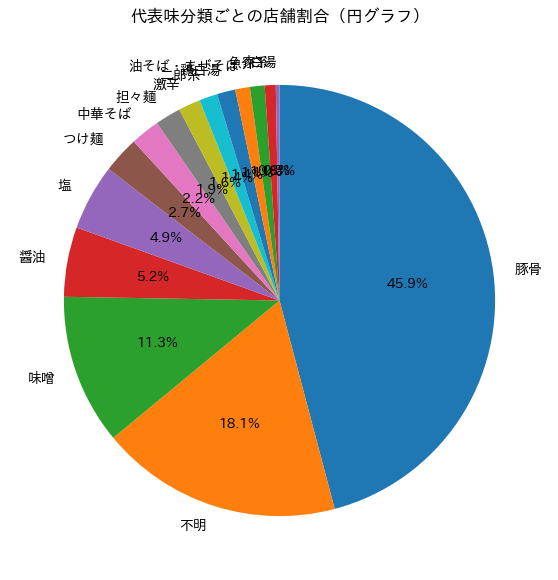

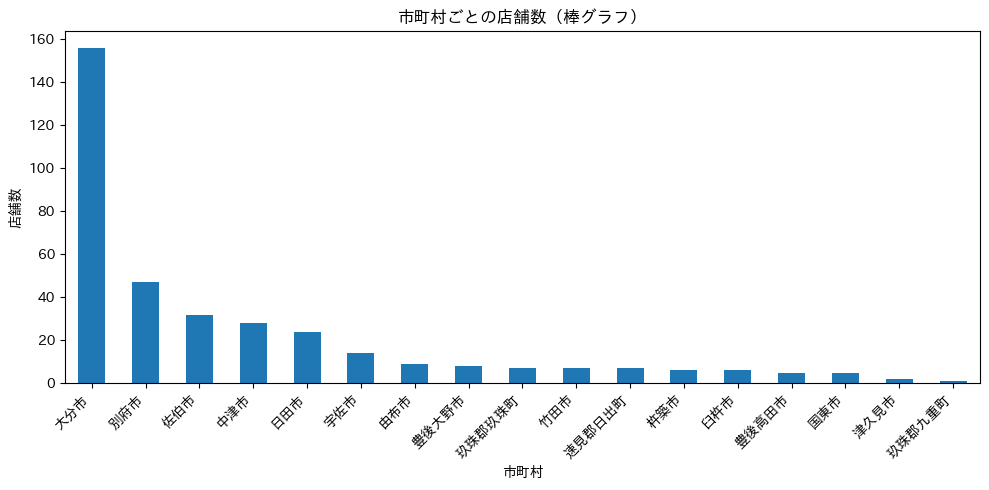

In [104]:
# 1. 代表味分類ごとの店舗数（円グラフ）
taste_count = df['代表味分類'].value_counts()

plt.figure(figsize=(7,7))
plt.pie(taste_count, labels=taste_count.index, autopct='%1.1f%%', startangle=90, counterclock=False)
plt.title('代表味分類ごとの店舗割合（円グラフ）')
plt.show()

# 2. 市町村ごとの店舗数（棒グラフ）
city_count = df['市町村'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(10,5))
city_count.plot(kind='bar')
plt.ylabel('店舗数')
plt.xlabel('市町村')
plt.title('市町村ごとの店舗数（棒グラフ）')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [105]:
# 数値型に変換
df1['評価'] = pd.to_numeric(df1['評価'], errors='coerce')
df1['レビュー数'] = pd.to_numeric(df1['レビュー数'], errors='coerce')
df1['ブックマーク数'] = pd.to_numeric(df1['ブックマーク数'], errors='coerce')  # 念のため

# 確認
print(df1[['評価', 'レビュー数', 'ブックマーク数']].dtypes)
print(df1.describe())

評価         float64
レビュー数      float64
ブックマーク数      int64
dtype: object
               評価       レビュー数       ブックマーク数
count  337.000000  349.000000    364.000000
mean     3.130772   35.985673    629.351648
std      0.132521   63.744121   1752.906022
min      3.000000    1.000000      1.000000
25%      3.040000    7.000000     53.000000
50%      3.070000   17.000000    173.000000
75%      3.210000   40.000000    500.000000
max      3.560000  753.000000  20003.000000


In [106]:
# 各項目の意味
# 	•	count: データ件数（欠損値以外のデータ数）
# 	•	例：評価がある店は337件、レビュー数は349件、ブックマーク数は364件
# 	•	mean: 平均値（合計を件数で割った値）
# 	•	例：評価の平均は3.13点、1店舗あたり平均レビュー数は約36件、ブックマーク数は629件
# 	•	std: 標準偏差（データの散らばり具合・ばらつき）
# 	•	例：評価は0.13、レビュー数は63.75、ブックマーク数は1752.80（ブックマーク数のばらつきが大きい）
# 	•	min: 最小値
# 	•	例：評価の最低は3.00点、レビュー数の最低は1件、ブックマーク数の最低は1件
# 	•	25%（第1四分位数）: データを小さい順に並べたとき、下位25%の値
# 	•	例：評価の下位25%は3.04点以下、レビュー数は7件以下
# 	•	50%（中央値・第2四分位数）: データの真ん中の値
# 	•	例：評価の中央値は3.07点、レビュー数の中央値は17件、ブックマーク数の中央値は173件
# 	•	75%（第3四分位数）: データの上位25%の値
# 	•	例：評価の上位25%は3.21点以上、レビュー数の上位25%は40件以上
# 	•	max: 最大値
# 	•	例：評価の最高は3.56点、レビュー数の最大は753件、ブックマーク数の最大は20001件

array([[<Axes: title={'center': '評価'}>,
        <Axes: title={'center': 'レビュー数'}>],
       [<Axes: title={'center': 'ブックマーク数'}>, <Axes: >]], dtype=object)

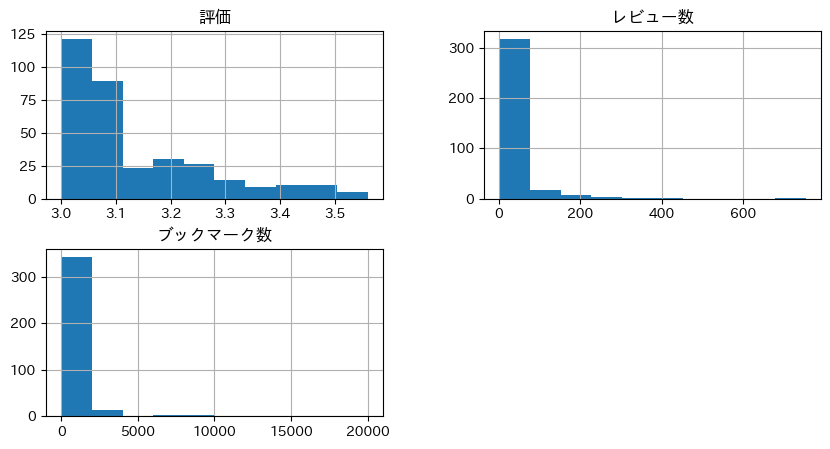

In [107]:
df1.hist()

In [37]:
# 各グラフ(ヒストグラム（度数分布図）)の意味
# 	•	評価
# 	•	ほとんどの店舗が「評価3.0～3.2」に集中していることが分かります。
# 	•	3.3以上の高評価店舗は少数です。
# 	•	レビュー数
# 	•	1～50件程度の店が大多数で、100件以上の店はまれです。
# 	•	右側（高レビュー数）のバーは少なく、外れ値（突出した多さ）の店もある。
# 	•	ブックマーク数
# 	•	多くの店舗はブックマーク数が1000件未満です。
# 	•	2000件、10000件を超えるような店はかなりの例外（超人気店）です。

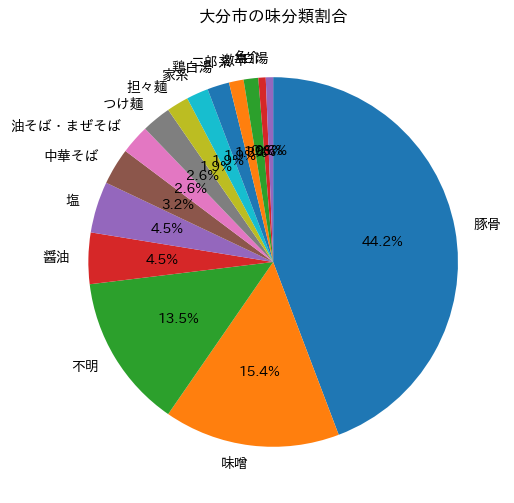

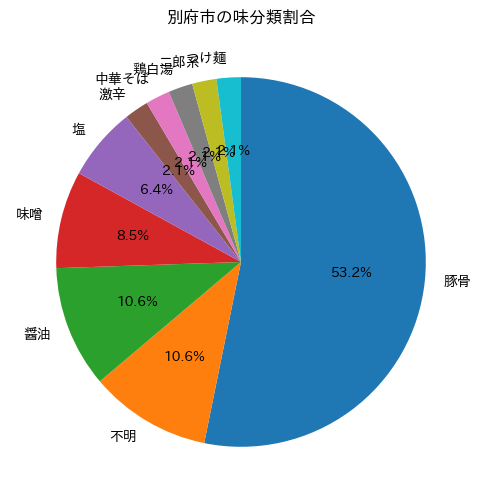

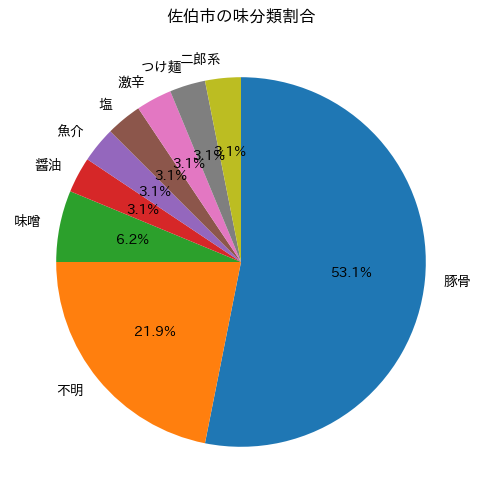

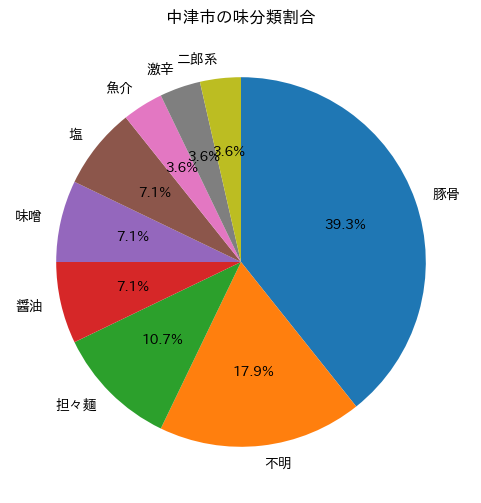

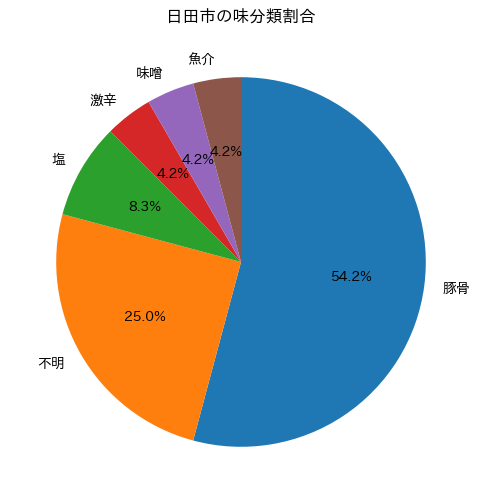

In [108]:
# 店舗数上位5市町村を抽出
top_cities = df['市町村'].value_counts().head(5).index

# 市町村ごとに円グラフ
for city in top_cities:
    sub_df = df[df['市町村'] == city]
    flavor_count = sub_df['代表味分類'].value_counts()
    plt.figure(figsize=(6,6))
    plt.pie(flavor_count, labels=flavor_count.index, autopct='%1.1f%%', startangle=90, counterclock=False)
    plt.title(f'{city}の味分類割合')
    plt.show()

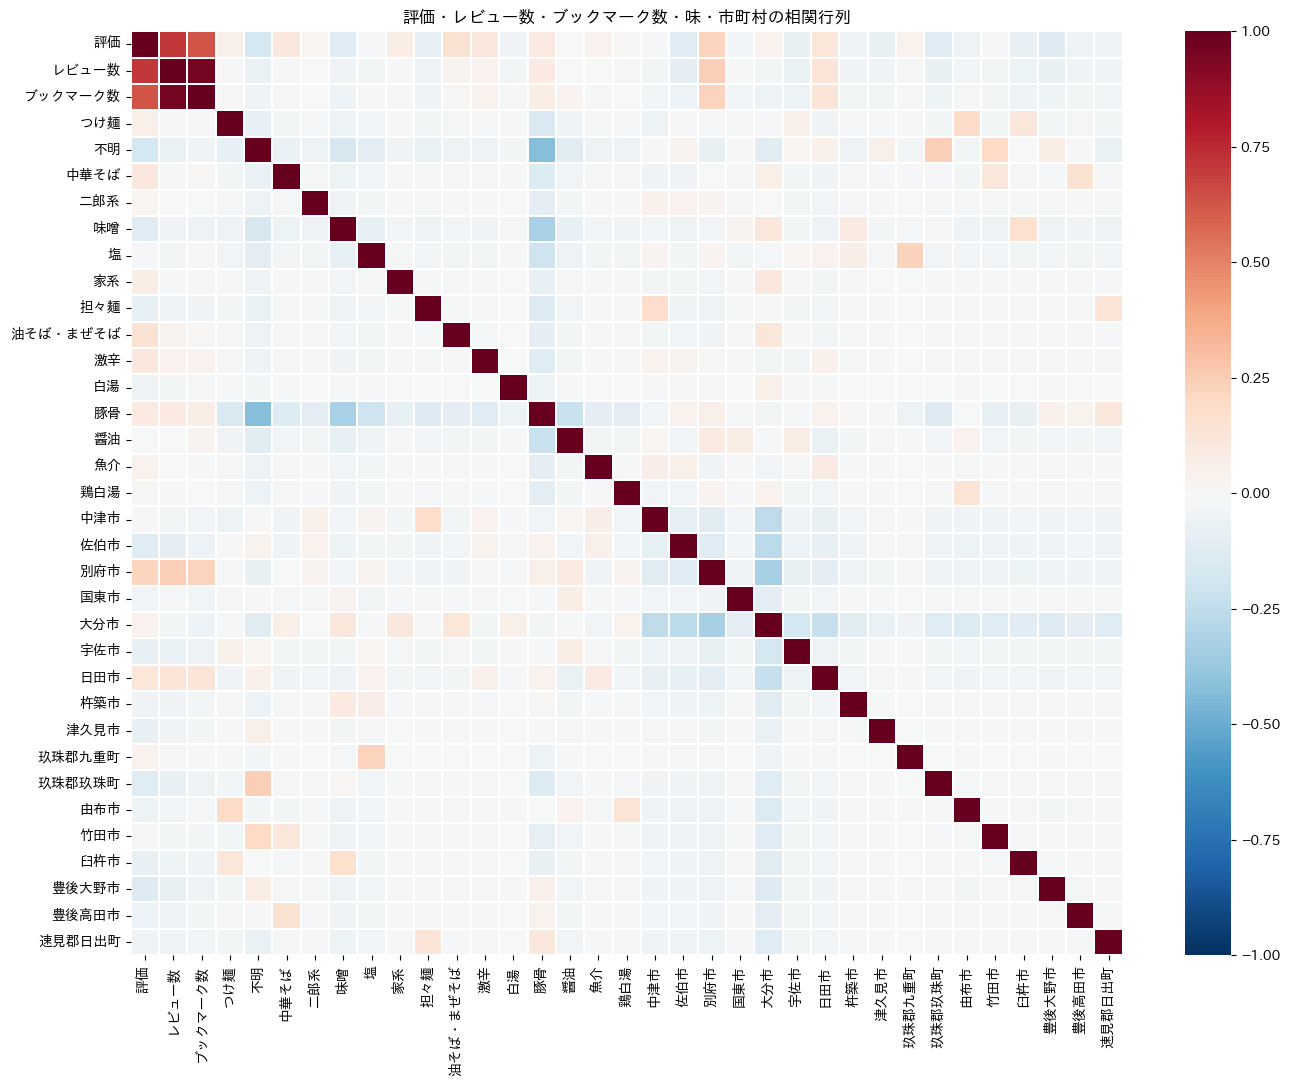

In [61]:
# 代表味分類、市町村をダミー変換（one-hot化）
df1_dummy = pd.get_dummies(df1[['代表味分類', '市町村']])

# 数値列とダミー変換列を結合
df1_corr = pd.concat([df1[['評価', 'レビュー数', 'ブックマーク数']], df1_dummy], axis=1)

# 相関行列を作成
corr_matrix = df1_corr.corr()

# ラベル（行・列名）のリネーム
def clean_label(s):
    s = s.replace('代表味分類_', '').replace('市町村_', '')
    return s

corr_matrix.rename(index=clean_label, columns=clean_label, inplace=True)

# ヒートマップを描画
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, linewidths=0.1, linecolor='white', cmap='RdBu_r', vmax=1.0, vmin=-1.0, annot=False)
plt.title('評価・レビュー数・ブックマーク数・味・市町村の相関行列')
plt.show()

In [58]:
# これは「別府市・日田市に美味しい店（高評価店）が比較的多い傾向がデータ上で確認できる」という意味であり、「必ず美味しい」や「評価の高い店しかない」という意味ではありません。
# 	•	評価が高い理由は「人気観光地でレビュー数が多くなりやすい」「高評価店が目立つ」など複合要因も考えられます。
# 	•	サンプル数が少ない市町村の場合、たまたま高評価店が多いだけの可能性もあるので「参考傾向」と捉えると良いです。
# まとめ
# 	•	赤い=正の相関→その市町村にある店は「評価がやや高い店が多い」傾向
# 	•	青い=負の相関→その市町村にある店は「評価がやや低い店が多い」傾向
# 	•	白に近い=相関ほぼなし

<Figure size 1200x600 with 0 Axes>

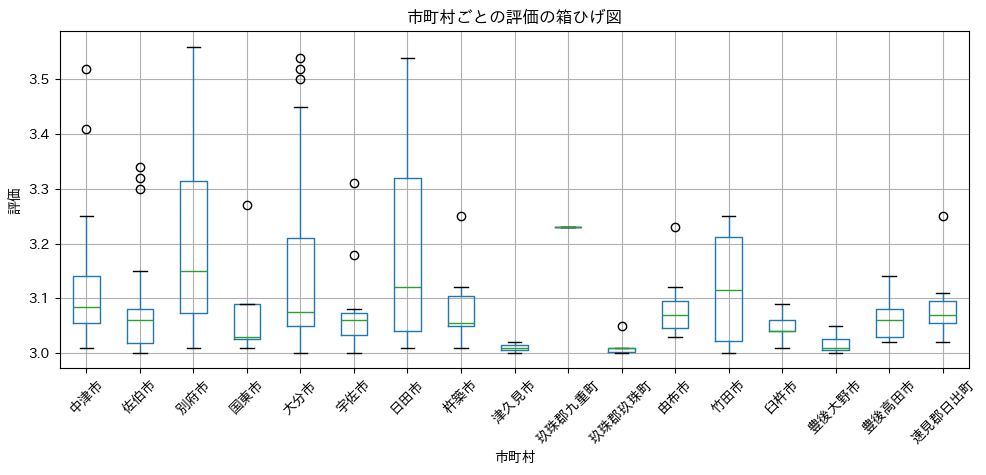

In [65]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
df1.boxplot(column='評価', by='市町村', rot=45)
plt.title('市町村ごとの評価の箱ひげ図')
plt.suptitle('')
plt.ylabel('評価')
plt.xlabel('市町村')
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

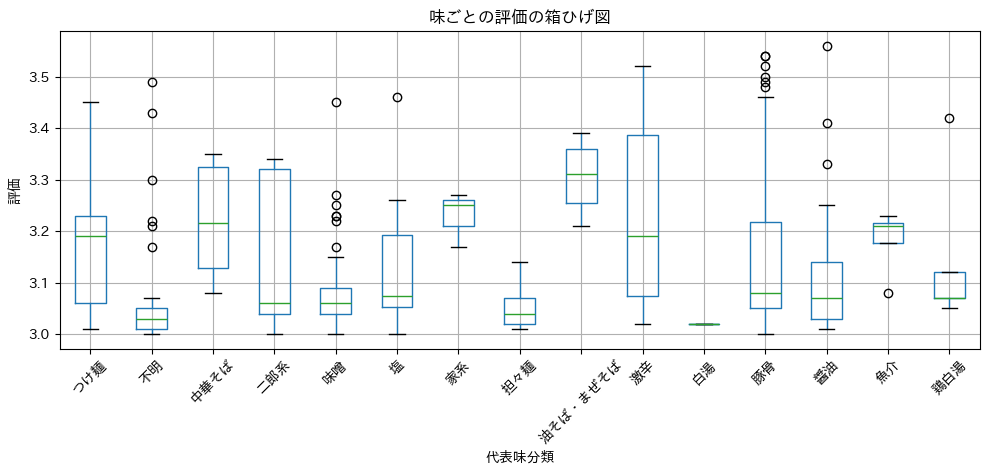

In [62]:
plt.figure(figsize=(12, 6))
df1.boxplot(column='評価', by='代表味分類', rot=45)
plt.title('味ごとの評価の箱ひげ図')
plt.suptitle('')
plt.ylabel('評価')
plt.xlabel('代表味分類')
plt.tight_layout()
plt.show()

【レビュー数グループの境界値】
少ない: 1.0〜10.0
普通: 11.0〜30.0
多い: 31.0〜753.0



<Figure size 800x600 with 0 Axes>

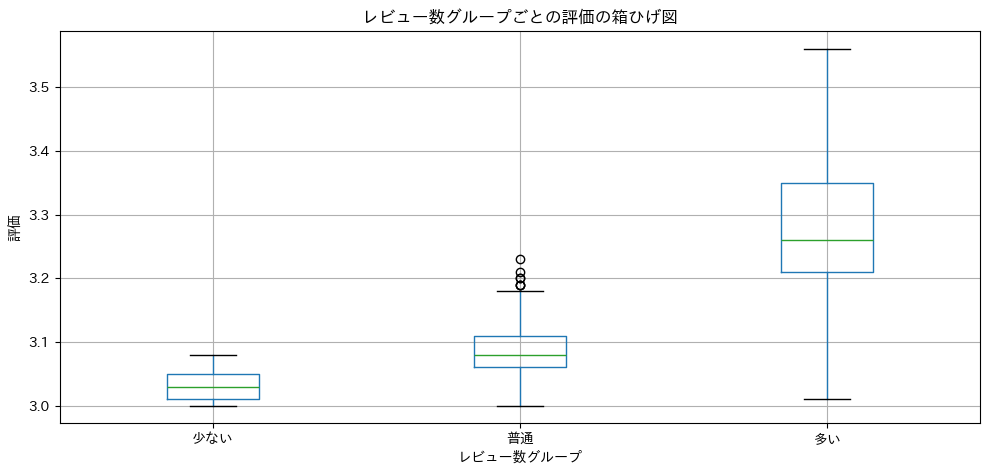

In [67]:
# レビュー数でグループ分け & 境界値出力
df1['レビュー数グループ'], bins_r = pd.qcut(df1['レビュー数'], 3, labels=['少ない', '普通', '多い'], retbins=True)
print(f'【レビュー数グループの境界値】\n少ない: {bins_r[0]}〜{bins_r[1]}\n普通: {bins_r[1]+1}〜{bins_r[2]}\n多い: {bins_r[2]+1}〜{bins_r[3]}\n')

plt.figure(figsize=(8, 6))
df1.boxplot(column='評価', by='レビュー数グループ')
plt.title('レビュー数グループごとの評価の箱ひげ図')
plt.suptitle('')
plt.ylabel('評価')
plt.xlabel('レビュー数グループ')
plt.tight_layout()
plt.show()

【ブックマーク数グループの境界値】
少ない: 1.0〜78.0
普通: 79.0〜325.0
多い: 326.0〜20001.0



<Figure size 800x600 with 0 Axes>

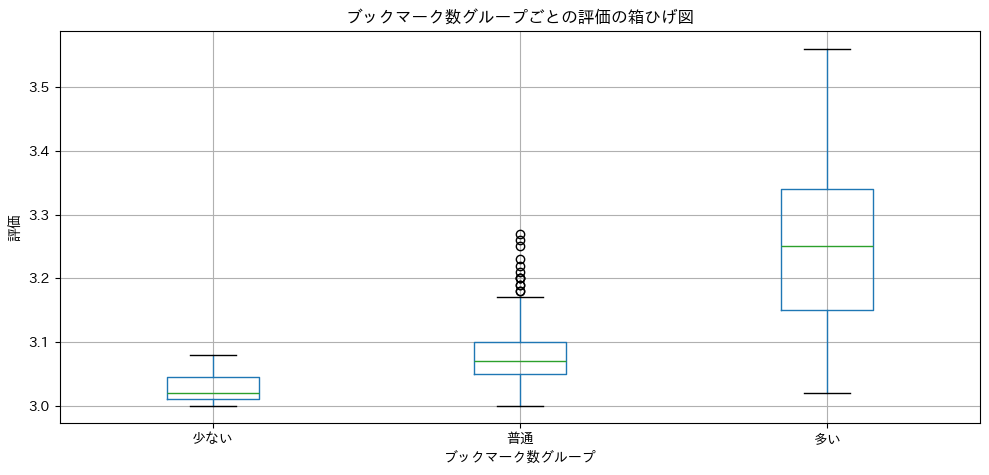

In [68]:

# ブックマーク数でグループ分け & 境界値出力
df1['ブックマーク数グループ'], bins_b = pd.qcut(df1['ブックマーク数'], 3, labels=['少ない', '普通', '多い'], retbins=True)
print(f'【ブックマーク数グループの境界値】\n少ない: {bins_b[0]}〜{bins_b[1]}\n普通: {bins_b[1]+1}〜{bins_b[2]}\n多い: {bins_b[2]+1}〜{bins_b[3]}\n')

plt.figure(figsize=(8, 6))
df1.boxplot(column='評価', by='ブックマーク数グループ')
plt.title('ブックマーク数グループごとの評価の箱ひげ図')
plt.suptitle('')
plt.ylabel('評価')
plt.xlabel('ブックマーク数グループ')
plt.tight_layout()
plt.show()

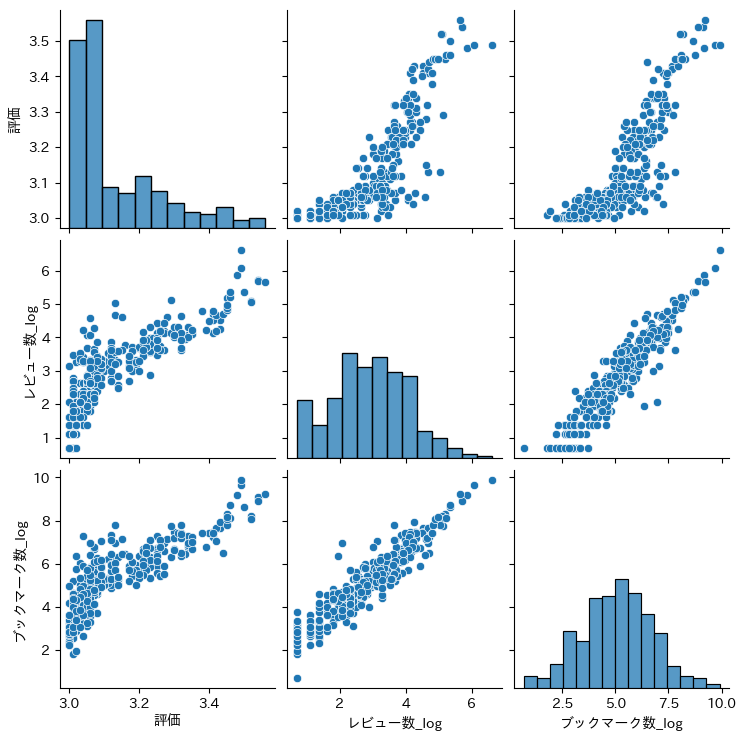

In [83]:
df2 = df1.copy()
df2['レビュー数_log'] = np.log1p(df2['レビュー数'])
df2['ブックマーク数_log'] = np.log1p(df2['ブックマーク数'])

sns.pairplot(df2, vars=['評価', 'レビュー数_log', 'ブックマーク数_log'])
plt.show()

切片（intercept）: 2.780533848401166
回帰係数（coefficient）: [0.0550914  0.03502399]
決定係数（R2）: 0.7214424575754838


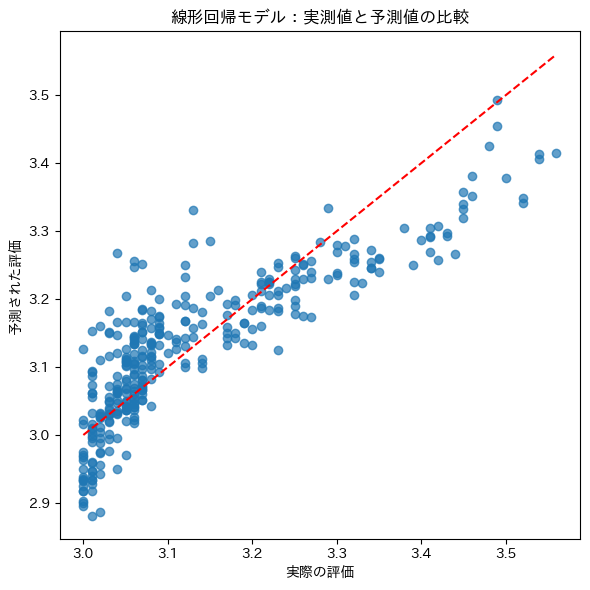

In [86]:
from sklearn.linear_model import LinearRegression
# データ準備
df2 = df1.copy()
df2['レビュー数_log'] = np.log1p(df2['レビュー数'])
df2['ブックマーク数_log'] = np.log1p(df2['ブックマーク数'])

# 欠損値を除外
df2 = df2[['評価', 'レビュー数_log', 'ブックマーク数_log']].dropna()

# 説明変数と目的変数
X = df2[['レビュー数_log', 'ブックマーク数_log']]
y = df2['評価']

# 線形回帰モデル作成＆学習
model = LinearRegression()
model.fit(X, y)

# 回帰係数・切片の確認
print("切片（intercept）:", model.intercept_)
print("回帰係数（coefficient）:", model.coef_)
print("決定係数（R2）:", model.score(X, y))

# 予測値
y_pred = model.predict(X)

# 実測値 vs 予測値の散布図
plt.figure(figsize=(6, 6))
plt.scatter(y, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('実際の評価')
plt.ylabel('予測された評価')
plt.title('線形回帰モデル：実測値と予測値の比較')
plt.tight_layout()
plt.show()

In [87]:
# グラフの見方
# 	•	青い点
# 	•	各店舗ごとに「本当の評価」と「モデルの予測値」をペアで並べた点
# 	•	点が赤い破線（45度の直線）に近いほど「予測がうまくいっている」という意味
# 	•	赤い破線
# 	•	「実際の評価」と「予測された評価」が完全に一致する場合の理想直線


# 点が理想線の近くに多く並んでいるので、「モデルの予測精度はかなり良い」と言えます
# 決定係数（R2）= 0.72
# これは「レビュー数_log」「ブックマーク数_log」から評価を約72%の精度で説明できていることを意味します

# 予測された評価は、「レビュー数」と「ブックマーク数」から自動計算された“予想スコア”
# 線形回帰モデルによって「店舗の評価が、レビュー数やブックマーク数でかなり良く予測できる」ことがこのグラフで分かります

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


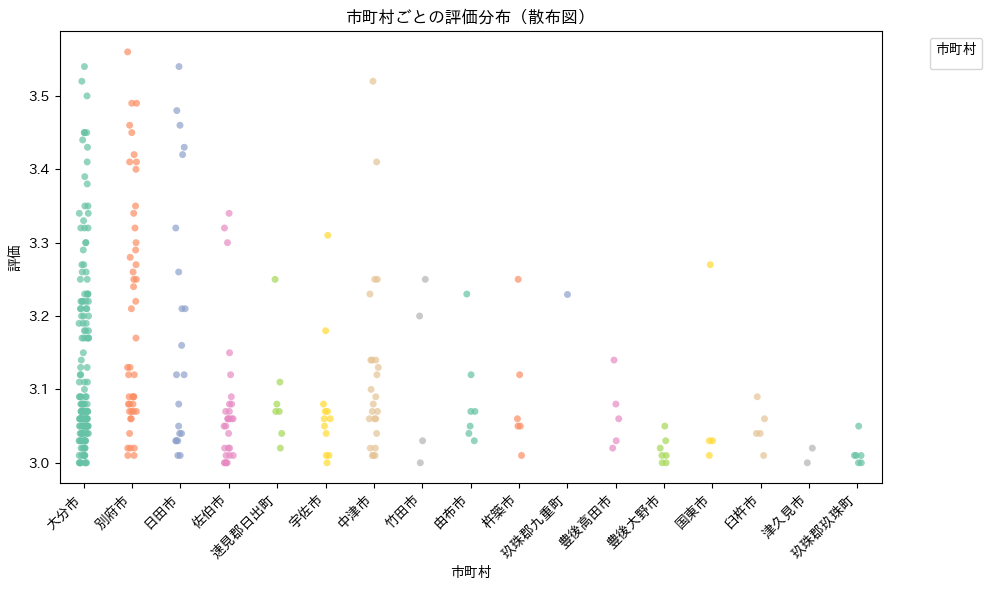

In [70]:
# 市町村ごとにカテゴリを色分けした散布図
plt.figure(figsize=(10, 6))
sns.stripplot(x='市町村', y='評価', data=df1, jitter=True, hue='市町村', dodge=False, palette='Set2', alpha=0.7)
plt.title('市町村ごとの評価分布（散布図）')
plt.xlabel('市町村')
plt.ylabel('評価')
plt.legend(title='市町村', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/tmp/ipykernel_21414/2582753923.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='代表味分類', y='評価', data=df1, jitter=True, palette='Set2', alpha=0.7)


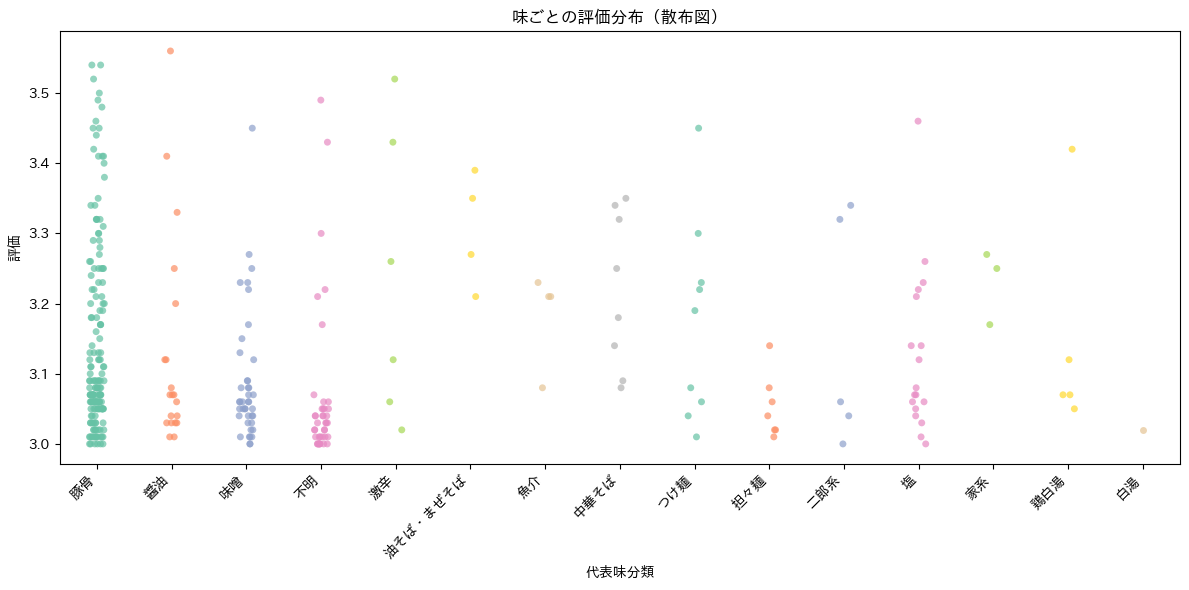

In [71]:
plt.figure(figsize=(12, 6))
sns.stripplot(x='代表味分類', y='評価', data=df1, jitter=True, palette='Set2', alpha=0.7)
plt.title('味ごとの評価分布（散布図）')
plt.xlabel('代表味分類')
plt.ylabel('評価')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

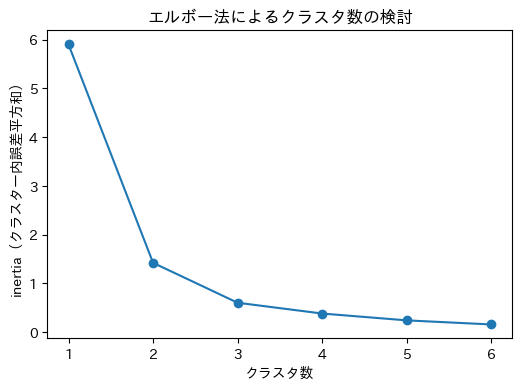

In [75]:
inertia = []
K = range(1, 7)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(X[['評価']])
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K, inertia, marker='o')
plt.xlabel('クラスタ数')
plt.ylabel('inertia（クラスター内誤差平方和）')
plt.title('エルボー法によるクラスタ数の検討')
plt.show()

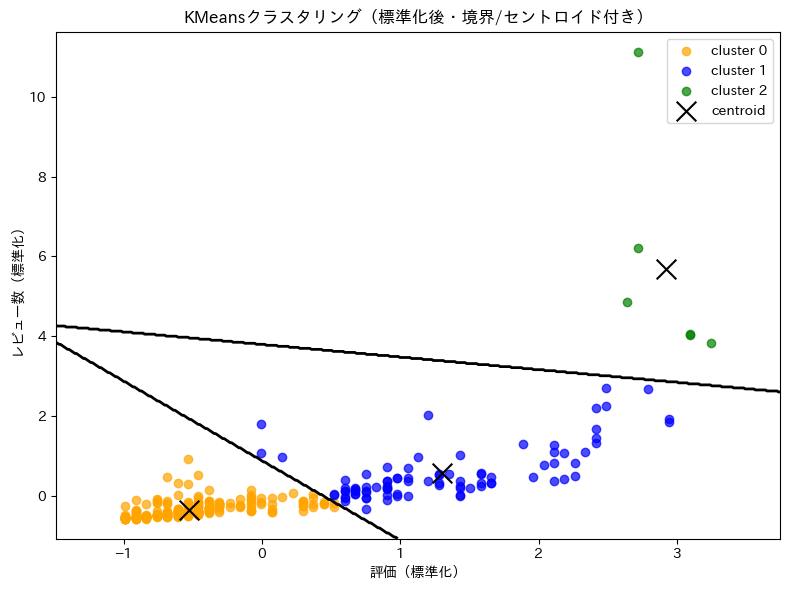

In [92]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# データ準備・標準化
X2 = df1[['評価', 'レビュー数']].dropna()
scaler = StandardScaler()
X2_scaled = scaler.fit_transform(X2)

# KMeansクラスタリング
kmeans2 = KMeans(n_clusters=3, random_state=0, n_init=10)
clusters2 = kmeans2.fit_predict(X2_scaled)

# プロット用データフレーム
X2_plot = pd.DataFrame(X2_scaled, columns=['評価', 'レビュー数'])
X2_plot['cluster'] = clusters2

# 描画
plt.figure(figsize=(8, 6))
colors = ['orange', 'blue', 'green']
for c in sorted(X2_plot['cluster'].unique()):
    mask = X2_plot['cluster'] == c
    plt.scatter(
        X2_plot['評価'][mask],
        X2_plot['レビュー数'][mask],
        color=colors[c], alpha=0.7, label=f'cluster {c}'
    )

# セントロイド（中心）を描画
centroids = kmeans2.cluster_centers_
plt.scatter(
    centroids[:, 0], centroids[:, 1],
    s=200, c='black', marker='x', label='centroid'
)

# 決定境界を描画
x_min, x_max = X2_plot['評価'].min()-0.5, X2_plot['評価'].max()+0.5
y_min, y_max = X2_plot['レビュー数'].min()-0.5, X2_plot['レビュー数'].max()+0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))
Z = kmeans2.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contour(xx, yy, Z, levels=np.arange(-0.5, 3), colors='k', linewidths=2)

plt.xlabel('評価（標準化）')
plt.ylabel('レビュー数（標準化）')
plt.title('KMeansクラスタリング（標準化後・境界/セントロイド付き）')
plt.legend()
plt.tight_layout()
plt.show()

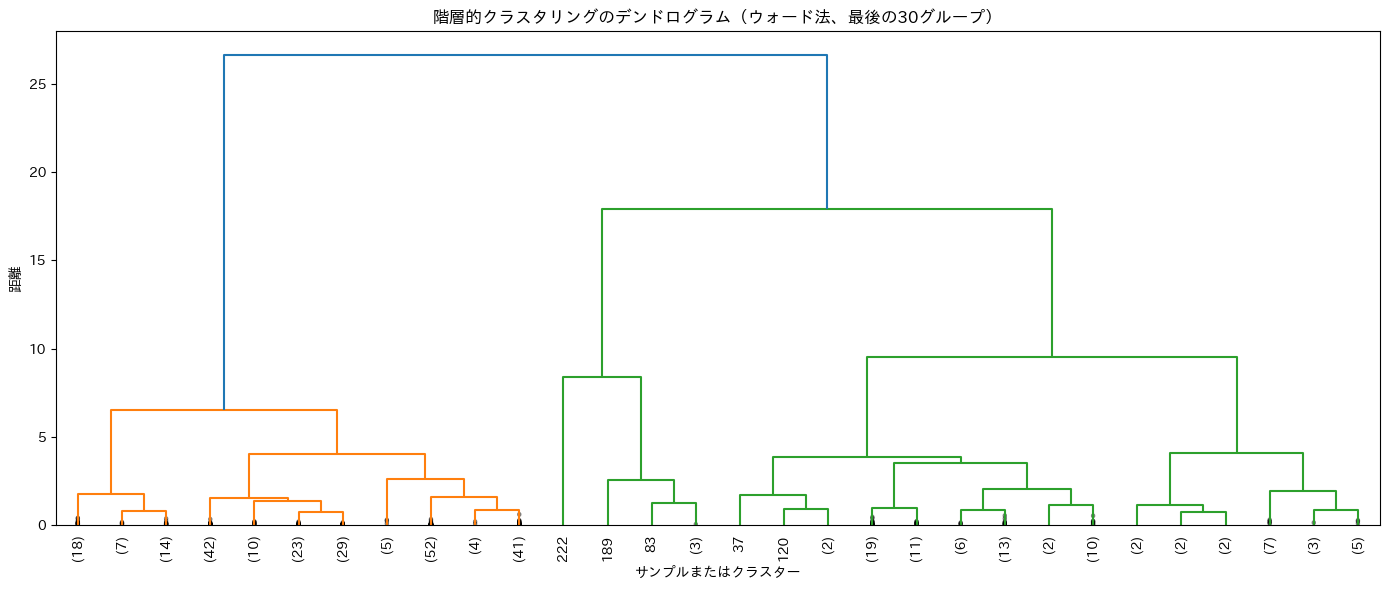

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.preprocessing import StandardScaler

# データ準備・標準化
X = df1[['評価', 'レビュー数']].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 階層的クラスタリング（ウォード法で距離計算）
linked = linkage(X_scaled, method='ward')

# デンドログラムの描画
plt.figure(figsize=(14, 6))
dendrogram(linked, truncate_mode='lastp', p=30, leaf_rotation=90., leaf_font_size=10., show_contracted=True)
plt.title('階層的クラスタリングのデンドログラム（ウォード法、最後の30グループ）')
plt.xlabel('サンプルまたはクラスター')
plt.ylabel('距離')
plt.tight_layout()
plt.show()

# 任意のクラスタ数に切る場合（例: 3クラスタ）
n_clusters = 3
clusters = fcluster(linked, n_clusters, criterion='maxclust')

# 元データにクラスタ番号追加
X_plot = pd.DataFrame(X_scaled, columns=['評価', 'レビュー数'])
X_plot['cluster'] = clusters

